In [1]:
%load_ext autoreload
%autoreload 2


In [4]:
import networkx as nx
import numpy as np
import cvxpy as cp
from tqdm import tqdm
from pathlib import Path

from src.load_data import (
    read_metadata_networks_tntp,
    read_graph_transport_networks_tntp,
    read_traffic_mat_transport_networks_tntp,
)

from src.models import SDModel, BeckmannModel, TwostageModel
from src.algs import subgd, ustm, frank_wolfe, cyclic
from src.cvxpy_solvers import get_max_traffic_mat_mul
from src.commons import Correspondences

import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 14})
%config InlineBackend.figure_format = 'retina'

%matplotlib inline

In [6]:
networks_path = Path("./TransportationNetworks")

folder = "SiouxFalls"
net_name = "SiouxFalls_net"
traffic_mat_name = "SiouxFalls_trips"

# folder = "Anaheim"
# net_name = "Anaheim_net"
# traffic_mat_name = "Anaheim_trips"
    
# folder = "Barcelona"
# net_name = "Barcelona_net"
# traffic_mat_name = "Barcelona_trips"
    
net_file = networks_path / folder / f"{net_name}.tntp"
traffic_mat_file = networks_path / folder / f"{traffic_mat_name}.tntp"
graph, metadata = read_graph_transport_networks_tntp(net_file)
correspondences = read_traffic_mat_transport_networks_tntp(traffic_mat_file, metadata)
n = graph.number_of_nodes()

print(f"{graph.number_of_edges()=}, {graph.number_of_nodes()=}")

metadata["can_pass_through_zones"]=True
graph.number_of_edges()=76, graph.number_of_nodes()=24


In [7]:
beckmann_model = BeckmannModel(graph, correspondences)

eps = 1e-6
mean_bw = beckmann_model.graph.ep.capacities.a.mean()
mean_cost = beckmann_model.graph.ep.free_flow_times.a.mean()

# cost suboptimality <= eps * (average link cost * avg bandwidth * |E| \approx total cost when beta=1)
eps_abs = eps * mean_cost * mean_bw * graph.number_of_edges()

eps_cons_abs = eps * mean_bw 
# sum of capacity violation <= eps * average link capacity
print(eps_abs, eps_cons_abs)

3.217622777832031 0.010247206298828124


# Beckmann

In [8]:
times_e_ustm, flows_e_ustm, logs, optimal = ustm(beckmann_model, eps_abs, max_iter=1000, stop_by_crit=True)
dgap_ustm, cons_log_ustm, time_log_ustm = logs
print(len(dgap_ustm), "shortest paths calls")


100%|██████████| 1000/1000 [00:32<00:00, 30.88it/s]

4028 shortest paths calls


In [9]:
times_e_fw, flows_e_fw, logs, optimal = frank_wolfe(beckmann_model, eps_abs,  max_iter=1000, stop_by_crit=False)
dgap_fw, time_log_fw = logs

100%|██████████| 1000/1000 [00:08<00:00, 116.75it/s]


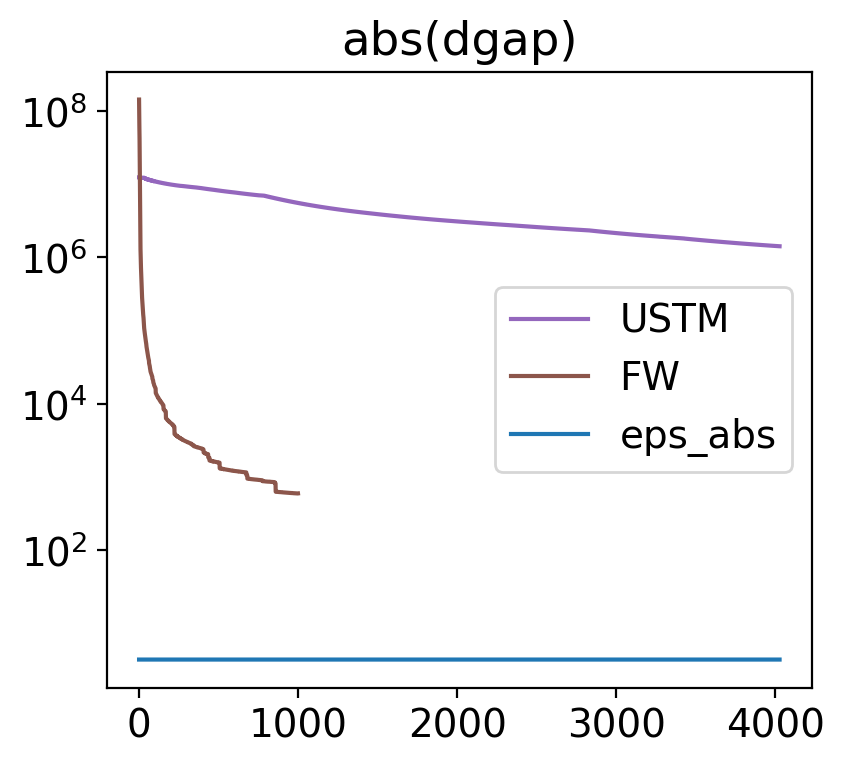

In [10]:
plt.figure(figsize=(10,4))
plt.subplot(121)
dgap_ustm = np.abs(dgap_ustm)
dgap_fw = np.abs(dgap_fw)
plt.plot(dgap_ustm, c="C4", label="USTM")
plt.plot(dgap_fw, c="C5", label="FW")
plt.plot(np.ones(max(dgap_ustm.size, dgap_fw.size)) * eps_abs, label="eps_abs")
plt.yscale("log")
plt.title("abs(dgap)")
plt.legend()


# SD

In [11]:
# %%time

# for Anaheim 18 min on my laptop (for np.ones matrix ~3 min, omg. maybe scaling impacts?). result \approx 0.529
# sd_max_traffic_mul = get_max_traffic_mat_mul(graph, correspondences.traffic_mat, solver=cp.SCS)
sd_max_traffic_mul = 0.529

# for SiouxFalls
# sd_max_traffic_mul = get_max_traffic_mat_mul(graph, correspondences.node_traffic_mat, solver=cp.ECOS, 
#                                              max_iters=1000, verbose=False)

print(f"{sd_max_traffic_mul=},")

corrs = Correspondences(traffic_mat=correspondences.traffic_mat * sd_max_traffic_mul * 0.9,
                        node_traffic_mat=correspondences.node_traffic_mat * sd_max_traffic_mul * 0.9,
                        sources=correspondences.sources,
                        targets=correspondences.targets)

sd_model = SDModel(graph, corrs)
# model = SDModel(graph, traffic_mat * sd_max_traffic_mul * 1.1)  # you should see that constraints error does not converge

sd_max_traffic_mul=0.529,


## cvxpy edge-based

## Ustm

In [ ]:
%%time

times_e_ustm, flows_e_ustm, logs, optimal = ustm(sd_model, eps_abs, eps_cons_abs,
                                                                         max_iter=1000, stop_by_crit=True)

dgap_ustm, cons_log_ustm, time_log_ustm = logs
print(len(dgap_ustm), "iters")


In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(121)
dgap_abs = np.abs(dgap_ustm)
plt.plot(dgap_abs, c="C4", label="USTM")
plt.plot(np.ones(dgap_abs.size) * eps_abs, label="eps_abs")
plt.yscale("log")
plt.ylim(None, dgap_abs.max() * 2)
plt.title("abs(dgap)")
plt.legend()

plt.subplot(122)
plt.plot(np.ones(len(cons_log_ustm)) * eps_cons_abs, label="eps_cons_abs")
plt.plot(cons_log_ustm, c="C4", label="USTM")
plt.title("constraint violation")
plt.yscale("log")
plt.legend()

In [ ]:
bws = sd_model.graph.ep.capacities.a
order = bws.argsort()

plt.plot(bws[order], label="capacity", c='C2')
# plt.plot(flows_cvx[order], label="cvxpy", c="C1")
plt.plot(flows_e_ustm[order], label="ustm", c="C4")

plt.legend()

# Subgd

In [ ]:
%%time

times_e_subgd, flows_e_subgd, logs, optimal = subgd(sd_model, R=10, eps_abs=eps_abs, 
                                                                   eps_cons_abs=eps_cons_abs, max_iter=1000)

dgap_subgd, cons_log_subgd = logs

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(121)
dgap_abs = np.abs(dgap_subgd)
plt.plot(np.ones(dgap_abs.size) * eps_abs, label="eps_abs")
plt.plot(dgap_abs, c="C3", label="subgd")
plt.legend()
plt.yscale("log")

plt.title("abs(dgap)")
plt.subplot(122)
plt.plot(np.ones(len(cons_log_subgd)) * eps_cons_abs, label="eps_cons_abs")
plt.plot(cons_log_subgd, c="C3", label="subgd")
plt.legend()
plt.title("constraint violation l1 norm")
plt.yscale("log")


In [ ]:
bws = sd_model.graph.ep.capacities.a
order = bws.argsort()

plt.plot(bws[order], label="capacity", c='C2')
# plt.plot(flows_cvx[order], label="cvxpy", c="C1")
plt.plot(flows_e_subgd[order], label="subgd", c="C4")

plt.legend()

# Twostage

In [ ]:
traffic_mat = beckmann_model.correspondences.traffic_mat 
departures, arrivals = traffic_mat.sum(axis=1), traffic_mat.sum(axis=0) 
twostage_beckmann_model = TwostageModel(beckmann_model, departures, arrivals, gamma=0.1)

print(eps_abs, eps_cons_abs)

In [ ]:
times_e_ustm, flows_e_ustm, traffic_mat, logs, optimal = cyclic(twostage_beckmann_model,
                                                                        eps_abs, eps_abs,
                                                                         max_iter=20,
                                                                        traffic_assigment_max_iter=100,
                                                                                 stop_by_crit=False)
dgap_cyclic, cons_log_cyclic, time_log_cyclic = logs

In [ ]:
times_ustm_2s, primal_var, logs, optimal = ustm(twostage_beckmann_model, eps_abs=1000, max_iter=300, stop_by_crit=False)
dgap_ustm_2s, cons_log_ustm_2s, time_log_ustm_2s = logs
print(len(dgap_ustm_2s), "iters")

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(time_log_cyclic, dgap_cyclic, c="C4", label="cyclic")
plt.plot(time_log_ustm_2s, dgap_ustm_2s, c="C6", label="ustm")
plt.yscale("log")
plt.title("dgap")
plt.legend()